# Tiramisu for Segmentation

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
import scipy.ndimage as pic
from concurrent.futures import ProcessPoolExecutor

## Setup

In [3]:
PATH ='../NOA_sealions/'
# frames_path = PATH+'Train/'
# dot_path = PATH+'TrainDotted/'

In [4]:
trn_ids = pd.read_csv('../IDsTrainingSet.txt')
tst_ids = pd.read_csv('../IDsforBlending.txt')
trn_ids = np.array(trn_ids.columns)
tst_ids = np.array(tst_ids.columns)
ids = np.hstack([trn_ids,tst_ids])
fnames = ['../NOA_sealions/Train/'+str(int(i))+'.jpg' for i in trn_ids]
tnames = ['../NOA_sealions/Train/'+str(int(i))+'.jpg' for i in tst_ids]
names = fnames+tnames

In [5]:
len(ids), len(names)

(907, 907)

In [6]:
# fnames = glob.glob(frames_path+'*.jpg')
print (fnames[0:3])

['../NOA_sealions/Train/1.jpg', '../NOA_sealions/Train/5.jpg', '../NOA_sealions/Train/8.jpg']


In [7]:
# dnames = [dot_path+os.path.basename(fn)[:-4]+'.jpg' for fn in fnames]
print (tnames[0:3])

['../NOA_sealions/Train/513.jpg', '../NOA_sealions/Train/2.jpg', '../NOA_sealions/Train/516.jpg']


In [8]:
img_sz = (360,360)

In [9]:
def open_image(fn): return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))

In [10]:
len(fnames),len(tnames)

(657, 250)

In [ ]:
# training and blending split
trn_imgs = np.stack([open_image(fn) for fn in fnames])
val_imgs = np.stack([open_image(fn) for fn in tnames])
trn_imgs.shape, val_imgs.shape

In [ ]:
# combining both for preprocessing
imgs = np.vstack([trn_imgs,val_imgs])
imgs.shape

In [ ]:
imgs = imgs/255.

In [ ]:
mean = imgs.mean() 
std = imgs.std()
mean, std

In [11]:
mean = 0.46484162619453223
std = 0.18947753792494046

In [ ]:
imgs-=mean
imgs/=std

In [ ]:
save_array('results/imgs.bc', imgs)

In [12]:
imgs = load_array('results/imgs.bc')

In [13]:
n,r,c,ch = imgs.shape

In [14]:
cord = pd.read_csv('coords.csv')
cord.cls = cord.cls+1

### Codes

In [15]:
seal = ['void', 'adult_males', 'subadult males', 'adult females', 'juveniles', 'pups']
rgb = [(0,0,0), (243,8,5), (244,8,242), (87,46,10), (25,56,176), (38,174,21)]  
cls = [0, 1, 2, 3, 4, 5]
hex = ['#000000', '#f30805', '#f408f2', '#572e0a', '#1938b0', '#26ae15']

In [16]:
seal2rgb = dict(zip(seal,rgb))
cls2rgb = dict(zip(cls, rgb))
cls2hex = dict(zip(cls, hex))
seal2cls = dict(zip(seal,cls))
cls2seal = dict(zip(cls,seal))
rgb2cls = dict(zip(rgb, cls))

### Labelling-Hardcore

In [17]:
img_sz = (360,360)

In [18]:
imgs.shape

(907, 360, 360, 3)

In [19]:
def create_labels(x,r=1):
    for i in range(-r,r):
        for j in range(-r,r):
            row = int((x['row']*img_sz[0])/actual.shape[0])
            col = int((x['col']*img_sz[1])/actual.shape[1])
            if (row+i)<img_sz[0] and (col+j)<img_sz[1]:
                label[(row + i), (col + j)] = x['cls'] # row,column

In [20]:
import sys

In [ ]:
%%time
target = []
for i in range(imgs.shape[0]):
    print('Processing for image = '+names[i])
    actual = pic.imread(names[i])
    id = int(ids[i])
    cordinates = cord[cord.tid==id]
    label = np.zeros(img_sz,dtype=int)
    a=cordinates.apply(create_labels, axis=1)
    target.append(label)

In [ ]:
labels_int = np.array(target)

In [21]:
labels_int.shape

(907, 360, 360)

In [24]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            o=cls2rgb[a[j,k]]
            res[j,k] = o
    return res

In [25]:
col_label = color_label(labels_int[90])
names[90]

'../NOA_sealions/Train/128.jpg'

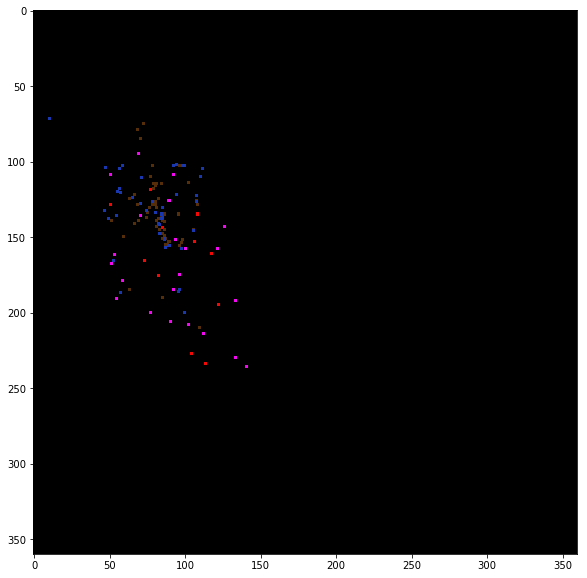

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(col_label)

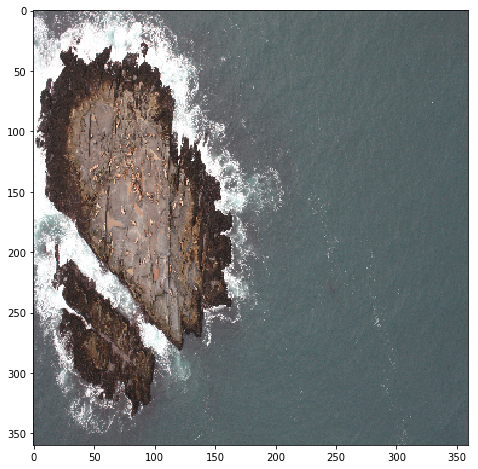

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(imgs[90]*std+mean)

In [ ]:
dot = imgs[9]

In [ ]:
for x in range(360):
    for y in range(360):
        if target[9][x,y]!=0:
            dot[x,y] = col_label[x,y]

In [ ]:
! mkdir labels

In [ ]:
save_array('labels/labels_int.bc', labels_int)

In [21]:
labels_int = load_array('labels/labels_int.bc')

## Processing

### Generator

In [27]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [28]:
bi = BatchIndices(10,4)
[next(bi) for o in range(5)]

[array([0, 1, 2, 3]),
 array([4, 5, 6, 7]),
 array([8, 9]),
 array([0, 1, 2, 3]),
 array([4, 5, 6, 7])]

In [29]:
temp = labels_int[0]

In [30]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        condition =True
        while True:
            slice_r = self.get_slice(self.ri, self.ro)
            slice_c = self.get_slice(self.ci, self.co)
            x = self.x[idx, slice_r, slice_c]
            y = self.y[idx, slice_r, slice_c]
            if self.train and (random.random()>0.5): 
                y = y[:,::-1]
                x = x[:,::-1]
            # Modified to create patches with atleast one sea lion
            if np.sum(y)!=0:
                break
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

### Visualizing generator

In [50]:
j, t_la = next(train_generator)

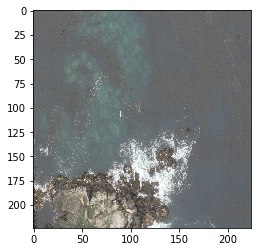

In [51]:
plt.imshow(j[0]*std+mean)

2123

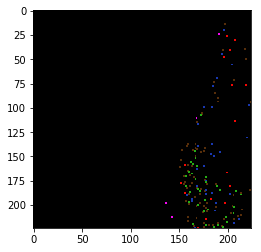

In [47]:
j, t_la = next(train_generator)
plt.figure(figsize=(4,4))
plt.imshow(color_label(np.resize(t_la[0], (224,224))))
np.sum(t_la[0])

In [56]:
t_la.shape

(4, 50176, 1)

## DATA SET

In [31]:
train_set = imgs[:657]
train_labels = labels_int[:657]

test_set = imgs[657:]
test_labels = labels_int[657:]

In [32]:
train_set.shape, test_set.shape, train_labels.shape, test_labels.shape

((657, 360, 360, 3), (250, 360, 360, 3), (657, 360, 360), (250, 360, 360))

## Tiramisu

### Pieces

In [33]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [34]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [35]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [36]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [37]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [38]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [39]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [40]:
def reverse(a): return list(reversed(a))

In [41]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## Train

In [42]:
from keras.utils.np_utils import to_categorical
lrg_sz = (224,224)
train_labels.shape,labels_int.shape

((657, 360, 360), (907, 360, 360))

In [44]:
train_generator = segm_generator(train_set, train_labels, 4, out_sz=lrg_sz ,train=True)
test_generator = segm_generator(test_set, test_labels, 4, out_sz=lrg_sz, train=False)

In [62]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5])

### Setting up training

In [49]:
input_shape = lrg_sz+(3,)
img_input = Input(shape=input_shape)

In [50]:
img_input = Input(shape=input_shape)

In [51]:
x = create_tiramisu(6, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [52]:
model = Model(img_input, x)

In [53]:
# #loss
# def sparse_categorical_crossentropy(y_true, y_pred):
#     true = K.clip(y_true,0,1)
#     pred = K.clip(y_pred,0,1)
#     loss = K.sum(K.clip((true-pred),0,1))
#     return (K.sparse_categorical_crossentropy(y_pred, y_true))*loss

In [54]:
# sess = tf.InteractiveSession()
# a = tf.constant([0,1,2,3,0,0])
# a=K.clip(a,0,1)
# b = tf.constant([0,0,0,0,1,1])
# a=K.sum(K.clip((a-b),0,1))
# a.eval(session=sess)

#### Start Training

In [55]:
from keras.callbacks import TensorBoard
from time import time
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [56]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [57]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [64]:
model.save_weights('after_7.h5')

In [65]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

Epoch 1/50
657/657 [==============================] - 254s - loss: 0.0339 - acc: 0.9952   
Epoch 2/50
657/657 [==============================] - 254s - loss: 0.0321 - acc: 0.9954   
Epoch 3/50
657/657 [==============================] - 254s - loss: 0.0319 - acc: 0.9954   
Epoch 4/50
657/657 [==============================] - 254s - loss: 0.0301 - acc: 0.9956   
Epoch 5/50
657/657 [==============================] - 253s - loss: 0.0309 - acc: 0.9952   
Epoch 6/50
657/657 [==============================] - 253s - loss: 0.0291 - acc: 0.9955   
Epoch 7/50
657/657 [==============================] - 253s - loss: 0.0290 - acc: 0.9955   
Epoch 8/50
657/657 [==============================] - 253s - loss: 0.0299 - acc: 0.9952   
Epoch 9/50
657/657 [==============================] - 253s - loss: 0.0267 - acc: 0.9957   
Epoch 10/50
657/657 [==============================] - 253s - loss: 0.0289 - acc: 0.9951   
Epoch 11/50
657/657 [==============================] - 253s - loss: 0.0261 - acc: 0.9957 

In [66]:
model.save_weights('after_50.h5')

In [67]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

Epoch 1/50
657/657 [==============================] - 253s - loss: 0.0232 - acc: 0.9953   
Epoch 2/50
657/657 [==============================] - 253s - loss: 0.0226 - acc: 0.9955   
Epoch 3/50
657/657 [==============================] - 253s - loss: 0.0233 - acc: 0.9953   
Epoch 4/50
657/657 [==============================] - 253s - loss: 0.0224 - acc: 0.9955   
Epoch 5/50
657/657 [==============================] - 253s - loss: 0.0217 - acc: 0.9957   
Epoch 6/50
657/657 [==============================] - 253s - loss: 0.0221 - acc: 0.9955   
Epoch 7/50
657/657 [==============================] - 253s - loss: 0.0223 - acc: 0.9955   
Epoch 8/50
657/657 [==============================] - 253s - loss: 0.0211 - acc: 0.9958   
Epoch 9/50
657/657 [==============================] - 253s - loss: 0.0225 - acc: 0.9955   
Epoch 10/50
657/657 [==============================] - 253s - loss: 0.0223 - acc: 0.9955   
Epoch 11/50
657/657 [==============================] - 253s - loss: 0.0220 - acc: 0.9956 

In [68]:
model.save_weights('after_100.h5')

In [69]:
model.optimizer=keras.optimizers.RMSprop(3e-4, decay=1-0.9995)

In [70]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

Epoch 1/50
657/657 [==============================] - 255s - loss: 0.0211 - acc: 0.9956   
Epoch 2/50
657/657 [==============================] - 253s - loss: 0.0215 - acc: 0.9955   
Epoch 3/50
657/657 [==============================] - 253s - loss: 0.0216 - acc: 0.9954   
Epoch 4/50
657/657 [==============================] - 253s - loss: 0.0218 - acc: 0.9954   
Epoch 5/50
657/657 [==============================] - 253s - loss: 0.0215 - acc: 0.9955   
Epoch 6/50
657/657 [==============================] - 253s - loss: 0.0207 - acc: 0.9956   
Epoch 7/50
657/657 [==============================] - 253s - loss: 0.0215 - acc: 0.9954   
Epoch 8/50
657/657 [==============================] - 253s - loss: 0.0212 - acc: 0.9955   
Epoch 9/50
657/657 [==============================] - 253s - loss: 0.0210 - acc: 0.9956   
Epoch 10/50
657/657 [==============================] - 253s - loss: 0.0221 - acc: 0.9953   
Epoch 11/50
657/657 [==============================] - 253s - loss: 0.0209 - acc: 0.9956 

In [71]:
model.save_weights('after_150.h5')

In [72]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

Epoch 1/50
657/657 [==============================] - 254s - loss: 0.0204 - acc: 0.9956   
Epoch 2/50
657/657 [==============================] - 254s - loss: 0.0217 - acc: 0.9953   
Epoch 3/50
657/657 [==============================] - 254s - loss: 0.0198 - acc: 0.9958   
Epoch 4/50
657/657 [==============================] - 254s - loss: 0.0200 - acc: 0.9957   
Epoch 5/50
657/657 [==============================] - 253s - loss: 0.0212 - acc: 0.9954   
Epoch 6/50
657/657 [==============================] - 254s - loss: 0.0209 - acc: 0.9955   
Epoch 7/50
657/657 [==============================] - 254s - loss: 0.0207 - acc: 0.9955   
Epoch 8/50
657/657 [==============================] - 254s - loss: 0.0201 - acc: 0.9957   
Epoch 9/50
657/657 [==============================] - 254s - loss: 0.0209 - acc: 0.9954   
Epoch 10/50
657/657 [==============================] - 254s - loss: 0.0212 - acc: 0.9955   
Epoch 11/50
657/657 [==============================] - 254s - loss: 0.0203 - acc: 0.9956 

KeyboardInterrupt: 

In [73]:
model.save_weights('after_200.h5')

In [74]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

Epoch 1/50
657/657 [==============================] - 256s - loss: 0.0211 - acc: 0.9954   
Epoch 2/50
657/657 [==============================] - 252s - loss: 0.0217 - acc: 0.9953   
Epoch 3/50
657/657 [==============================] - 253s - loss: 0.0196 - acc: 0.9958   
Epoch 4/50
657/657 [==============================] - 252s - loss: 0.0210 - acc: 0.9955   
Epoch 5/50
657/657 [==============================] - 253s - loss: 0.0206 - acc: 0.9954   
Epoch 6/50
657/657 [==============================] - 252s - loss: 0.0190 - acc: 0.9959   
Epoch 7/50
657/657 [==============================] - 253s - loss: 0.0207 - acc: 0.9955   
Epoch 8/50
657/657 [==============================] - 253s - loss: 0.0212 - acc: 0.9953   
Epoch 9/50
657/657 [==============================] - 253s - loss: 0.0197 - acc: 0.9957   
Epoch 10/50
641/657 [============================>.] - ETA: 6s - loss: 0.0204 - acc: 0.9955

In [ ]:
model.save_weights('after_250.h5')

In [ ]:
model.fit_generator(train_generator, len(train_set), nb_epoch=50, verbose=1)

In [ ]:
model.save_weights('after_300.h5')

### Testing

In [ ]:
try_image = np.array(Image.open('Train/41.jpg').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

In [ ]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)
try_preds.shape

In [ ]:
min(try_preds[0][:][:,0])

In [ ]:
try_preds = np.argmax(try_preds, axis=-1)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))

#### Class Weights

In [ ]:
total = np.count_nonzero(labels_int!=10)
cls1 = []
cls0 = []
for i in range(n):
    total = np.count_nonzero(labels_int[i]!=10)
    cls1.append(np.count_nonzero(labels_int[i]==1)/total)
    cls0.append(np.count_nonzero(labels_int[i]==0)/total)

In [ ]:
weight=[(1/np.mean(cls0)),(1/np.mean(cls1))] 
clss = [0,1]
class_weights = dict(zip(clss, weight))

In [ ]:
np.unique(labels_int)

In [ ]:
class_weights